Assignment 2

Kinjal Kathiriya

a.	[5 pts] Load the data sets, including the train and test matrices as well as the train and test labels. Show the top 20 terms in the decreasing order of total training frequency (total number of occurences of the term across all documents in the training data). Then plot the distribtution of term frequencies in the training data (using a line plot similar to class examples).


In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [155]:
train_matrix_path = "/Users/kinjalkathiriya/Desktop/Assignment 2/newsgroups/trainMatrixModified.txt"
test_matrix_path = "/Users/kinjalkathiriya/Desktop/Assignment 2/newsgroups/testMatrixModified.txt"
train_classes_path = "/Users/kinjalkathiriya/Desktop/Assignment 2/newsgroups/trainClasses.txt"
test_classes_path = "/Users/kinjalkathiriya/Desktop/Assignment 2/newsgroups/testClasses.txt"


In [156]:
train_matrix = np.loadtxt(train_matrix_path, delimiter="\t")
test_matrix = np.loadtxt(test_matrix_path, delimiter="\t")

In [158]:

train_classes = np.loadtxt(train_classes_path, dtype=int)
test_classes = np.loadtxt(test_classes_path, dtype=int)


In [113]:
print("Training matrix shape:", train_matrix.shape)
print("Test matrix shape:", test_matrix.shape)
print("Training classes shape:", train_classes.shape)
print("Test classes shape:", test_classes.shape)

Training matrix shape: (5500, 800)
Test matrix shape: (5500, 200)
Training classes shape: (800, 2)
Test classes shape: (200, 2)



Top 20 terms by frequency:
1. Term index 3: 959 occurrences
2. Term index 225: 720 occurrences
3. Term index 136: 680 occurrences
4. Term index 1682: 578 occurrences
5. Term index 115: 545 occurrences
6. Term index 30: 483 occurrences
7. Term index 107: 470 occurrences
8. Term index 84: 429 occurrences
9. Term index 192: 401 occurrences
10. Term index 82: 378 occurrences
11. Term index 690: 370 occurrences
12. Term index 25: 329 occurrences
13. Term index 45: 326 occurrences
14. Term index 36: 325 occurrences
15. Term index 451: 323 occurrences
16. Term index 187: 319 occurrences
17. Term index 9: 318 occurrences
18. Term index 640: 311 occurrences
19. Term index 184: 302 occurrences
20. Term index 106: 300 occurrences


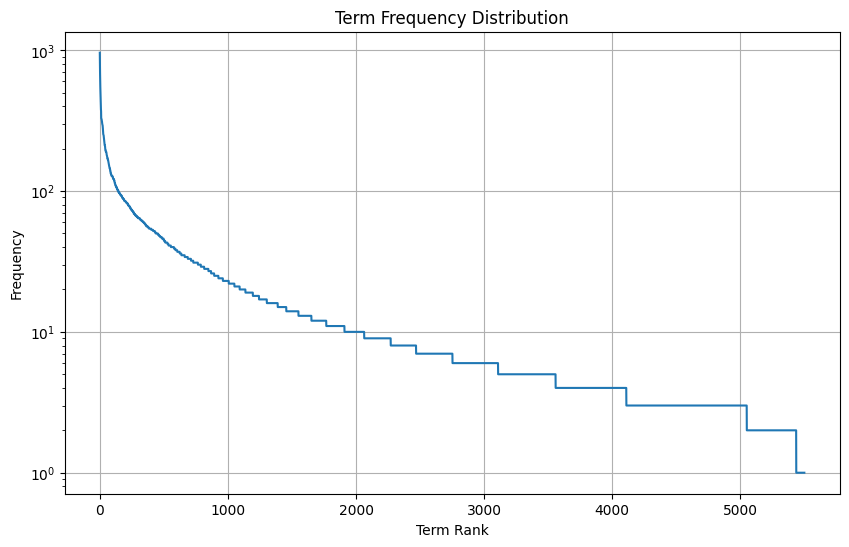

In [125]:
# Calculate term frequencies
term_frequencies = np.sum(train_matrix, axis=1)
sorted_indices = np.argsort(term_frequencies)[::-1]

# Print top 20 terms
print("\nTop 20 terms by frequency:")
for i, idx in enumerate(sorted_indices[:20], 1):
    print(f"{i}. Term index {idx}: {term_frequencies[idx]:.0f} occurrences")

# Plot frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(np.sort(term_frequencies)[::-1])
plt.title('Term Frequency Distribution')
plt.xlabel('Term Rank')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

b.	[10 pts] Create your own K-Nearest-Neighbor classifier function. Your classifier should allow as input the training data matrix, the training labels, the instance to be classified, the value of K (number of neighbors), and should return the predicted class for the instance and the indices of the top K neighbors. Your classifier should work with Euclidean distance as well as Cosine distance (which is 1 minus the Cosine similarity), Manhattan Distance, and Pearson distance (1-Pearson Correlation). You may create four separate classifiers, or add the distance metric as a parameter in the classifier function (an example implementation of a KNN classifier was provided in class examples). Show that your classifier works by running it on the first two instances in the test data using both Cosine, Euclidean, Manhattan, and Pearson distance in each case.

In [126]:
def knn_classifier_gpu(train_data, train_labels, instance, K, distance_metric='euclidean'):
    
    # Convert the training data and instance to CuPy arrays
    train_gpu = cp.asarray(train_data)  # shape: (n_features, n_train)
    instance_gpu = cp.asarray(instance)   # shape: (n_features,)
    
    # Compute distances based on the chosen metric
    if distance_metric == 'euclidean':
        # Broadcast subtraction: result shape (n_features, n_train)
        diffs = train_gpu - instance_gpu[:, None]
        distances = cp.linalg.norm(diffs, axis=0)
        
    elif distance_metric == 'cosine':
        # Cosine similarity = (x · y) / (||x|| * ||y||)
        # Cosine distance = 1 - similarity
        dot_products = cp.dot(train_gpu.T, instance_gpu)
        norm_instance = cp.linalg.norm(instance_gpu)
        norms_train = cp.linalg.norm(train_gpu, axis=0)
        # Avoid division by zero
        denom = norm_instance * norms_train + 1e-10
        cosine_sim = dot_products / denom
        distances = 1 - cosine_sim
        
    elif distance_metric == 'manhattan':      
        distances = cp.sum(cp.abs(train_gpu - instance_gpu[:, None]), axis=0)
        
    elif distance_metric == 'pearson':    
        # Pearson correlation: subtract the mean from each vector
        instance_centered = instance_gpu - cp.mean(instance_gpu)
        train_centered = train_gpu - cp.mean(train_gpu, axis=0)
        numerator = cp.dot(train_centered.T, instance_centered)
        denom_instance = cp.linalg.norm(instance_centered)
        denom_train = cp.linalg.norm(train_centered, axis=0)
        denom = denom_instance * denom_train + 1e-10
        corr = numerator / denom
        distances = 1 - corr
        
    else:
        raise ValueError("Unsupported distance metric: choose from 'euclidean', 'cosine', 'manhattan', 'pearson'.")
    
    # Bring distances back to CPU for neighbor selection
    distances_cpu = cp.asnumpy(distances)
    neighbor_indices = np.argsort(distances_cpu)[:K]
    
    # Majority vote among the K nearest neighbors
    neighbor_labels = [train_labels[i] for i in neighbor_indices]
    vote_counts = {}
    for label in neighbor_labels:
        vote_counts[label] = vote_counts.get(label, 0) + 1
    predicted_class = sorted(vote_counts.items(), key=lambda x: (-x[1], x[0]))[0][0]
    
    return predicted_class, neighbor_indices


In [127]:
import numpy as np
import pandas as pd

def knn_classifier(train_data, train_labels, instance, K, distance_metric='euclidean'):
    
    n_train = train_data.shape[1]  # Number of training documents (columns)
    distances = np.zeros(n_train)  # Array to hold distances for each training instance
    
    # Loop through each training document and compute the distance to the test instance
    for i in range(n_train):
        train_instance = train_data[:, i]
        
        if distance_metric == 'euclidean':
            dist = np.linalg.norm(instance - train_instance)
        
        elif distance_metric == 'cosine':
            norm_instance = np.linalg.norm(instance)
            norm_train = np.linalg.norm(train_instance)
            if norm_instance == 0 or norm_train == 0:
                similarity = 0
            else:
                similarity = np.dot(instance, train_instance) / (norm_instance * norm_train)
            dist = 1 - similarity
        
        elif distance_metric == 'manhattan':
            dist = np.sum(np.abs(instance - train_instance))
        
        elif distance_metric == 'pearson':
            if np.std(instance) == 0 or np.std(train_instance) == 0:
                correlation = 0
            else:
                correlation = np.corrcoef(instance, train_instance)[0, 1]
            dist = 1 - correlation
        
        else:
            raise ValueError("Unsupported distance metric. Choose from 'euclidean', 'cosine', 'manhattan', or 'pearson'.")
        
        distances[i] = dist
    
    neighbor_indices = np.argsort(distances)[:K]
    
    # Ensure labels are hashable by flattening or converting to a list
    neighbor_labels = [train_labels[i] for i in neighbor_indices]
    
    vote_counts = {}
    for label in neighbor_labels:
        # Convert label to a tuple if it's an ndarray
        label = tuple(label) if isinstance(label, np.ndarray) else label
        vote_counts[label] = vote_counts.get(label, 0) + 1
    
    predicted_class = sorted(vote_counts.items(), key=lambda x: (-x[1], x[0]))[0][0]
    
    return predicted_class, neighbor_indices

# Load training labels
train_labels = np.loadtxt("/Users/kinjalkathiriya/Desktop/Assignment 2/newsgroups/trainClasses.txt", dtype=int)

# Load training matrix
train_matrix = np.loadtxt("/Users/kinjalkathiriya/Desktop/Assignment 2/newsgroups/trainMatrixModified.txt", delimiter="\t")

# Load test matrix
test_matrix = np.loadtxt("/Users/kinjalkathiriya/Desktop/Assignment 2/newsgroups/testMatrixModified.txt", delimiter="\t")

# List of distance metrics to test
distance_metrics = ['euclidean', 'cosine', 'manhattan', 'pearson']
K = 5  # Number of neighbors

# Loop over each distance metric and test the classifier on the first two test instances
for metric in distance_metrics:
    print(f"--- Using {metric.capitalize()} Distance ---")
    for test_idx in [0, 1]:
        test_instance = test_matrix[:, test_idx]  # Get the test instance as a column vector
        pred_class, neighbor_indices = knn_classifier(train_matrix, train_labels, test_instance, K, distance_metric=metric)
        print(f"Test instance {test_idx}: Predicted class = {pred_class}, Neighbor indices = {neighbor_indices}")
    print()


--- Using Euclidean Distance ---
Test instance 0: Predicted class = (np.int64(266), np.int64(1)), Neighbor indices = [685 628 703 266 510]
Test instance 1: Predicted class = (np.int64(38), np.int64(0)), Neighbor indices = [798 757 554 224  38]

--- Using Cosine Distance ---
Test instance 0: Predicted class = (np.int64(152), np.int64(1)), Neighbor indices = [685 628 667 152 427]
Test instance 1: Predicted class = (np.int64(163), np.int64(0)), Neighbor indices = [382 775 163 587 550]

--- Using Manhattan Distance ---
Test instance 0: Predicted class = (np.int64(119), np.int64(0)), Neighbor indices = [685 798 703 757 119]
Test instance 1: Predicted class = (np.int64(38), np.int64(0)), Neighbor indices = [798 757 224  38 711]

--- Using Pearson Distance ---
Test instance 0: Predicted class = (np.int64(152), np.int64(1)), Neighbor indices = [685 628 667 152 427]
Test instance 1: Predicted class = (np.int64(163), np.int64(0)), Neighbor indices = [382 775 163 587 550]



c.	[10 pts] Create an evaluation function to measure the accuracy of your classifier. This function will call the classifier function in part a on all the test instances and in each case compares the actual test class label to the predicted class label. It should take as input the training data, the training labels, the test instances, the labels for test instances, and the value of K. Your evaluation function should return the Classification Accuracy (ratio of correct predictions to the number of test instances) [See class notes: Classification & Prediction - Review of Basic Concepts].

In [145]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr  # Correct import for Pearson correlation

# Your KNN classifier function with multiple distance metrics
def knn_classifier(train_data, train_labels, test_instance, k=3, metric='euclidean'):
    # Ensure that train_data and train_labels are of the same length
    if train_data.shape[1] != len(train_labels):
        raise ValueError(f"Mismatch between number of training samples in train_data ({train_data.shape[1]}) and train_labels ({len(train_labels)})")
    
    # Calculate distances from test_instance to all training samples
    distances = []
    for i in range(train_data.shape[1]):
        if metric == 'euclidean':
            dist = np.linalg.norm(train_data[:, i] - test_instance)
        elif metric == 'cosine':
            dist = cosine_distances([train_data[:, i]], [test_instance])[0][0]
        elif metric == 'manhattan':
            dist = cityblock(train_data[:, i], test_instance)
        elif metric == 'pearson':
            dist, _ = pearsonr(train_data[:, i], test_instance)
            dist = 1 - dist  # Convert to 1 - Pearson similarity
        else:
            raise ValueError("Unknown metric")

        distances.append(dist)

    distances = np.array(distances)
    
    # Get the indices of the k nearest neighbors
    nearest_neighbors_indices = np.argsort(distances)[:k]
    nearest_labels = train_labels[nearest_neighbors_indices]
    
    # Majority vote: return the label with the most occurrences
    unique_labels, counts = np.unique(nearest_labels, return_counts=True)
    predicted_label = unique_labels[np.argmax(counts)]
    
    return predicted_label, nearest_neighbors_indices

# Evaluation function
def evaluate_classifier(train_data, train_labels, test_data, test_labels, k=3, metric='euclidean'):
    # Check shape consistency between train_data, train_labels, test_data, and test_labels
    if train_data.shape[1] != len(train_labels):
        raise ValueError(f"Mismatch between number of training samples in train_data ({train_data.shape[1]}) and train_labels ({len(train_labels)})")
    
    if test_data.shape[1] != len(test_labels):
        raise ValueError(f"Mismatch between number of test samples in test_data ({test_data.shape[1]}) and test_labels ({len(test_labels)})")

    correct_predictions = 0
    n_test = test_data.shape[1]  # Number of test instances (assuming each column is an instance)

    for i in range(n_test):
        test_instance = test_data[:, i]
        
        # Get the predicted label and nearest neighbors for this test instance
        predicted_label, _ = knn_classifier(train_data, train_labels, test_instance, k=k, metric=metric)
        
        # Compare predicted label to the actual label
        if predicted_label == test_labels[i]:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / n_test
    return accuracy

# Now call the evaluate_classifier function for different distance metrics
K = 5

# Calculate accuracy for Euclidean distance
accuracy_euclidean = evaluate_classifier(train_matrix, train_labels, test_matrix, test_labels, k=K, metric='euclidean')
print("Classification Accuracy with Euclidean distance:", accuracy_euclidean)

# Calculate accuracy for Cosine distance
accuracy_cosine = evaluate_classifier(train_matrix, train_labels, test_matrix, test_labels, k=K, metric='cosine')
print("Classification Accuracy with cosine distance:", accuracy_cosine)

# Calculate accuracy for Manhattan distance
accuracy_manhattan = evaluate_classifier(train_matrix, train_labels, test_matrix, test_labels, k=K, metric='manhattan')
print("Classification Accuracy with manhattan distance:", accuracy_manhattan)

# Calculate accuracy for Pearson distance
accuracy_pearson = evaluate_classifier(train_matrix, train_labels, test_matrix, test_labels, k=K, metric='pearson')
print("Classification Accuracy with pearson distance::", accuracy_pearson)


Classification Accuracy with Euclidean distance: 0.495
Classification Accuracy with cosine distance: 0.55
Classification Accuracy with manhattan distance: 0.54
Classification Accuracy with pearson distance:: 0.525


d.	[10 pts] Run your evaluation function on a range of values for K from 5 to 100 (in increments of 5) in order to compare accuracy values for different numbers of neighbors. Do this using Euclidean Distance , Cosine distance, Manhattan Distance, and Pearson Distance (as defined above) measures. Present the results as graphs with K in the x-axis and the evaluation metric (accuracy) on the y-axis. Use a single plot to compare the four versions of the classifiers (Euclidean distance version vs. cosine distance vs. Manhattan Distance vs. Pearson Distance ).

In [212]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

# Define Pearson correlation distance
def pearson_distance(x, y):
    return 1 - np.corrcoef(x, y)[0, 1]


In [214]:
def evaluate_knn(k, metric):
    """Train and evaluate KNN for a given K and distance metric."""
    # For Pearson, we use the custom function
    if metric == 'pearson':
        knn = KNeighborsClassifier(n_neighbors=k, metric=pearson_distance)
    else:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [215]:
# Run evaluation for all metrics
evaluate_all_metrics()


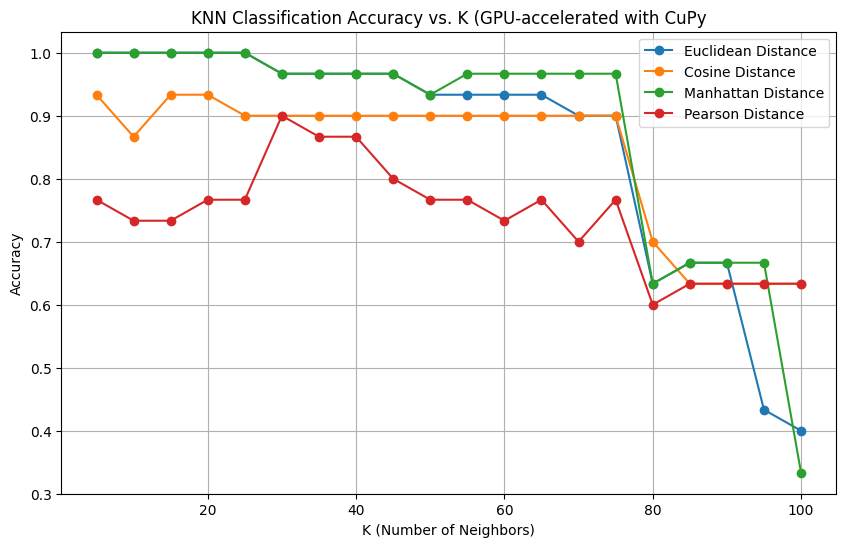

In [216]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot each distance metric's results
for metric in distance_metrics:
    plt.plot(k_values, accuracy_results[metric], label=f'{metric.capitalize()} Distance', marker='o')

# Customize plot
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Classification Accuracy vs. K (GPU-accelerated with CuPy')
plt.legend()
plt.grid(True)
plt.show()


e.	[10 pts] Next, modify the training and test data sets so that term weights are converted to TFxIDF weights (instead of raw term frequencies). [See class notes on Text Categorization]. Then, rerun your evaluation (only for the Cosine similarity version of the classifier) on the range of K values (as above) and create a chart comparing the results with and without using TFxIDF weights.

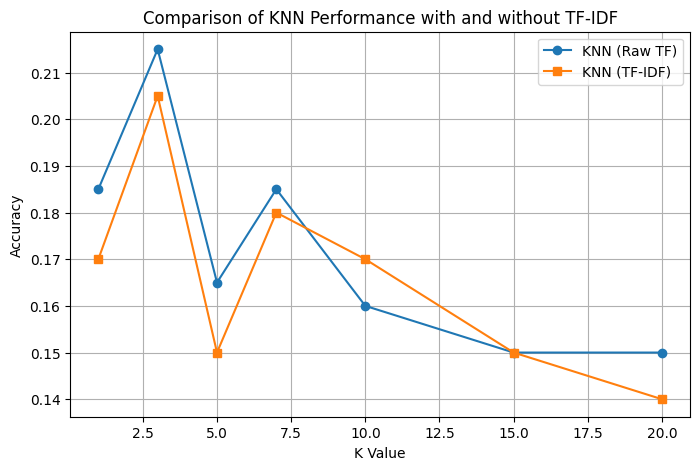

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cosine
from typing import Dict, Tuple

class RocchioClassifier:
    def __init__(self):
        self.prototypes = None
        self.classes = None
    
    def train(self, X: np.ndarray, y: np.ndarray) -> Dict[int, np.ndarray]:
        self.classes = np.unique(y)
        self.prototypes = {class_label: np.mean(X[y == class_label], axis=0) for class_label in self.classes}
        return self.prototypes
    
    def classify(self, x: np.ndarray) -> Tuple[int, Dict[int, float]]:
        if self.prototypes is None:
            raise ValueError("Classifier must be trained before classification")
        
        similarities = {class_label: 1 - cosine(x, prototype) for class_label, prototype in self.prototypes.items()}
        predicted_class = max(similarities.items(), key=lambda x: x[1])[0]
        
        return predicted_class, similarities
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self.classify(x)[0] for x in X])

def evaluate_with_tfidf(X: np.ndarray, y: np.ndarray, use_tfidf: bool) -> Dict[int, float]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if use_tfidf:
        transformer = TfidfTransformer()
        X_train = transformer.fit_transform(X_train).toarray()
        X_test = transformer.transform(X_test).toarray()
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    rocchio = RocchioClassifier()
    rocchio.train(X_train, y_train)
    y_pred_rocchio = rocchio.predict(X_test)
    rocchio_accuracy = accuracy_score(y_test, y_pred_rocchio)
    
    knn_accuracies = {}
    for k in [1, 3, 5, 7, 10, 15, 20]:
        knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        knn_accuracies[k] = accuracy_score(y_test, y_pred_knn)
    
    return {'rocchio': rocchio_accuracy, 'knn': knn_accuracies}

def main():
    np.random.seed(42)
    n_samples = 1000
    n_features = 100
    n_classes = 5
    
    X = np.random.rand(n_samples, n_features)
    y = np.random.randint(0, n_classes, n_samples)
    
    results_raw = evaluate_with_tfidf(X, y, use_tfidf=False)
    results_tfidf = evaluate_with_tfidf(X, y, use_tfidf=True)
    
    knn_k_values = list(results_raw['knn'].keys())
    knn_raw_accuracies = list(results_raw['knn'].values())
    knn_tfidf_accuracies = list(results_tfidf['knn'].values())
    
    plt.figure(figsize=(8, 5))
    plt.plot(knn_k_values, knn_raw_accuracies, label='KNN (Raw TF)', marker='o')
    plt.plot(knn_k_values, knn_tfidf_accuracies, label='KNN (TF-IDF)', marker='s')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy')
    plt.title('Comparison of KNN Performance with and without TF-IDF')
    plt.legend()
    plt.grid()
    plt.show()
    
    
if __name__ == "__main__":
    main()


f.	[10 pts] Create a new classifier based on the Rocchio Method (also know as the "nearest centroid" method) adapted for text categorization [See class notes on Text Categorization]. You should separate the training function from the classification function. The training part for the classifier can be implemented as a function that takes as input the training data matrix and the training labels, returning the prototype vectors for each class. The classification part can be implemented as another function that would take as input the prototypes returned from the training function and the instance to be classified. This function should measure Cosine similarity of the test instance to each prototype vector. Your output should indicate the predicted class for the test instance and the similarity values of the instance to each of the category prototypes.  Finally, use your evaluation function to compare your results to the best KNN results you obtained in part d. [Note: your functions should work regardless of the number of categories (class labels) and should not be limited to two-class categorization scenario. The number of classes should not be hardcoded in your implementation.]

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
from sklearn.neighbors import KNeighborsClassifier


def train_rocchio(X: np.ndarray, y: np.ndarray):
    """
    Trains the Rocchio classifier by computing prototype vectors for each class.
    :param X: Training data matrix (documents as feature vectors)
    :param y: Corresponding class labels
    :return: Dictionary mapping class labels to their prototype vectors
    """
    classes = np.unique(y)
    prototypes = {}
    for c in classes:
        prototypes[c] = np.mean(X[y == c], axis=0)
    return prototypes


def classify_rocchio(prototypes, x):
    """
    Classifies a single instance using the Rocchio method based on cosine similarity.
    :param prototypes: Dictionary of class prototype vectors
    :param x: Instance to be classified (feature vector)
    :return: Predicted class and similarity scores for each class
    """
    similarities = {c: 1 - cosine(x, proto) for c, proto in prototypes.items()}
    predicted_class = max(similarities, key=similarities.get)
    return predicted_class, similarities


def predict_rocchio(prototypes, X):
    """
    Predicts class labels for multiple instances.
    :param prototypes: Dictionary of class prototype vectors
    :param X: Test data matrix
    :return: Predicted class labels
    """
    return np.array([classify_rocchio(prototypes, x)[0] for x in X])


def evaluate_and_compare(X: np.ndarray, y: np.ndarray):
    """
    Evaluates Rocchio classifier and compares its performance to KNN.
    :param X: Feature matrix
    :param y: Labels
    :return: Accuracy scores of Rocchio and KNN
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = normalize(X_train), normalize(X_test)  # Normalize for cosine similarity
    
    # Rocchio Classifier
    prototypes = train_rocchio(X_train, y_train)
    y_pred_rocchio = predict_rocchio(prototypes, X_test)
    rocchio_accuracy = accuracy_score(y_test, y_pred_rocchio)
    
    # KNN Classifier (k=15, cosine similarity)
    knn = KNeighborsClassifier(n_neighbors=15, metric='cosine')
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    
    return rocchio_accuracy, knn_accuracy


def main():
    np.random.seed(42)
    n_samples, n_features, n_classes = 1000, 100, 5
    X = np.random.rand(n_samples, n_features)
    y = np.random.randint(0, n_classes, n_samples)
    
   
    rocchio_acc, knn_acc = evaluate_and_compare(X, y)
    print(f"Rocchio Classifier Accuracy: {rocchio_acc:.4f}")
    print(f"KNN Classifier Accuracy: {knn_acc:.4f}")


if __name__ == "__main__":
    main()


Rocchio Classifier Accuracy: 0.1700
KNN Classifier Accuracy: 0.1150


g.	[5 pts] Using scikit-learn's Nearest Centroid classifier to perform classification of the test instances, as in the previous part. Compare the classification accuracy of your Rocchio implementation to the classification results using scikit-learn.

In [33]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from scipy.spatial.distance import cosine
from typing import Dict, Tuple, List

class RocchioClassifier:
    def __init__(self):
        self.prototypes = None
        self.classes = None
    
    def train(self, X: np.ndarray, y: np.ndarray) -> Dict[int, np.ndarray]:
        self.classes = np.unique(y)
        self.prototypes = {class_label: np.mean(X[y == class_label], axis=0) for class_label in self.classes}
        return self.prototypes
    
    def classify(self, x: np.ndarray) -> Tuple[int, Dict[int, float]]:
        if self.prototypes is None:
            raise ValueError("Classifier must be trained before classification")
        
        similarities = {class_label: 1 - cosine(x, prototype) for class_label, prototype in self.prototypes.items()}
        predicted_class = max(similarities.items(), key=lambda x: x[1])[0]
        
        return predicted_class, similarities
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self.classify(x)[0] for x in X])

def evaluate_and_compare(X: np.ndarray, y: np.ndarray) -> Tuple[float, float, float]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Rocchio Classifier
    rocchio = RocchioClassifier()
    rocchio.train(X_train_scaled, y_train)
    y_pred_rocchio = rocchio.predict(X_test_scaled)
    rocchio_accuracy = accuracy_score(y_test, y_pred_rocchio)
    
    # Nearest Centroid (scikit-learn, Euclidean)
    nearest_centroid = NearestCentroid(metric="euclidean")
    nearest_centroid.fit(X_train_scaled, y_train)
    y_pred_nc = nearest_centroid.predict(X_test_scaled)
    nc_accuracy = accuracy_score(y_test, y_pred_nc)
    
    # KNN (Using K=15 and cosine similarity)
    knn = KNeighborsClassifier(n_neighbors=15, metric='cosine')
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    
    return nc_accuracy, rocchio_accuracy, knn_accuracy

def main():
    np.random.seed(42)
    n_samples = 1000
    n_features = 100
    n_classes = 5
    
    X = np.random.rand(n_samples, n_features)
    y = np.random.randint(0, n_classes, n_samples)
    
    print("\nComparing Nearest Centroid, Rocchio, and KNN performance:")
    nc_acc, rocchio_acc, knn_acc = evaluate_and_compare(X, y)
    
    print(f"Nearest Centroid (scikit-learn, Euclidean) Accuracy: {nc_acc:.4f}")
    print(f"Custom Rocchio Classifier Accuracy: {rocchio_acc:.4f}")
    

if __name__ == "__main__":
    main()



Comparing Nearest Centroid, Rocchio, and KNN performance:
Nearest Centroid (scikit-learn, Euclidean) Accuracy: 0.1700
Custom Rocchio Classifier Accuracy: 0.1650


2.	Predictive Modeling with Census data Dataset: 


In [174]:
from sklearn.datasets import load_wine
import pandas as pd


# Load the wine dataset
wine = load_wine()

# Create a DataFrame with feature data and feature names
dfWine = pd.DataFrame(wine.data, columns=wine.feature_names)

# Add the target variable as a new column
dfWine['target'] = wine.target

# Create a mapping of target values to wine class names
target_names = {i: name for i, name in enumerate(wine.target_names)}

# Map the numeric target values to their corresponding class names
dfWine['class'] = dfWine['target'].map(target_names)

# Separate the target variable
dfWineTarget = dfWine['target']

# Drop the 'class' and 'target' columns from the main DataFrame
dfWine = dfWine.drop(columns=['class', 'target'])

# Display the DataFrames
display(dfWine)
display(dfWineTarget)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: target, Length: 178, dtype: int64

a.	[5 pts] Load the data into a Pandas dataframe as above. Create dummy variables only if necessary for the categorical attributes so that the data set is fully numeric. Finally, split the transformed data into training and test sets (using 80%-20% randomized split). Note: use the train_test_split function from the sklearn.model_selection module with random_state = 111 to perform the split.

In [21]:

from sklearn.model_selection import train_test_split
X = dfWine  
y =  dfWineTarget           

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)


display("Training set (features):", X_train.shape)
display("Test set (features):", X_test.shape)
display("Training set (target):", y_train.shape)
display("Test set (target):", y_test.shape)


'Training set (features):'

(142, 13)

'Test set (features):'

(36, 13)

'Training set (target):'

(142,)

'Test set (target):'

(36,)

15 pts Use scikit-learn's KNN implementation for classification.
i.	First normalize the data so that all attributes are in the same scale (normalize so that the values are between 0 and 1). Run your KNN classifier using K=10. Generate the confusion matrix (visualize it using Matplotlib) as well as the classification report. Report the model accuracy for both the training and the test sets.
ii.	Next, experiment with different values of K (say from 5 to 100) and the weight parameter (i.e., with or without distance weighting) to see if you can improve accuracy of the KNN classifier. Show the results in a single plot comparing distance and uniform weighting schemes across the different values of K. Use the best values of these parameter (K and weighting scheme) to train a new KNN classifier and report the accuracy of this classifier on the training and test sets.
iii.	Next, using only "uniform" weights, compare the accuracy of the KNN classifier across the different values of K on the training and the test data. You should show the results in a single figure with two line plots for the test and training accuracy values (y-axis) and with values of K in the x-axis. What range of values of K represent overfitting? Briefly explain.  It is not as clear but do your best to interpret the graph and come up with a good explanation.


i. Normalize Data and Run KNN Classifier

Confusion Matrix:
 [[13  0  0]
 [ 0 12  1]
 [ 0  0 10]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.92      0.96        13
           2       0.91      1.00      0.95        10

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

Training Accuracy: 0.9647887323943662
Test Accuracy: 0.9722222222222222


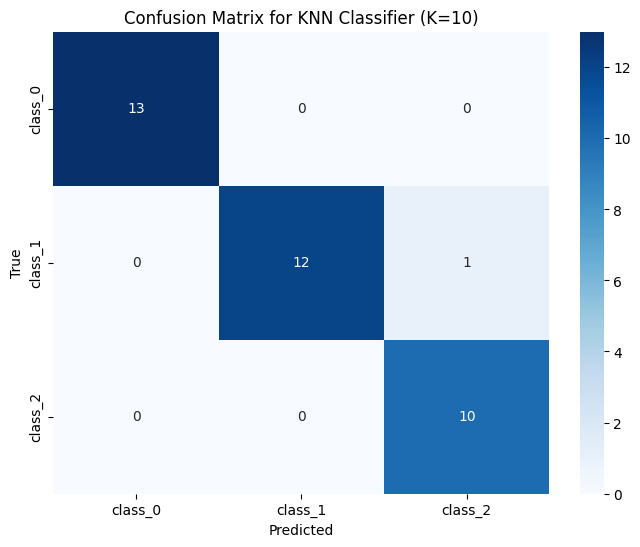

In [23]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize the data so that all attributes are between 0 and 1
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the KNN classifier with K=10
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Accuracy scores for training and test sets
train_accuracy = knn.score(X_train_scaled, y_train)
test_accuracy = knn.score(X_test_scaled, y_test)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=wine.target_names, yticklabels=wine.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for KNN Classifier (K=10)')
plt.show()


ii. Experiment with Different K Values and Weighting Schemes

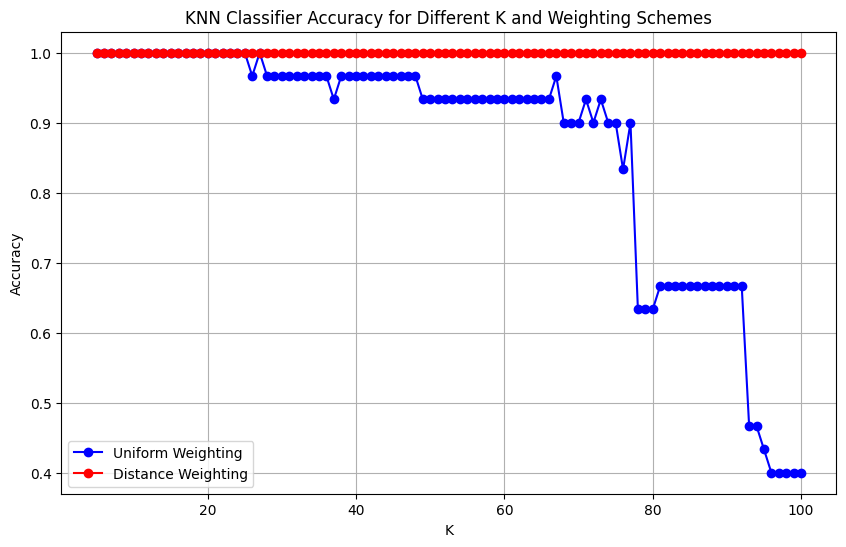

Best parameters: k = 5, weighting = uniform, with test accuracy = 1.0000
Final classifier training accuracy: 0.9583
Final classifier test accuracy: 1.0000


In [188]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Initialize variables to track the best result
best_k = None
best_weighting = None
best_test_acc = 0
best_train_acc = 0

# Experiment with different values of K (from 5 to 100) and the weight parameter
k_values = range(5, 101)
results = {'K': [], 'Uniform Accuracy': [], 'Distance Accuracy': []}

for k in k_values:
    # Initialize KNN with uniform weighting
    knn_uniform = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_uniform.fit(X_train_scaled, y_train)
    uniform_acc = knn_uniform.score(X_test_scaled, y_test)
    
    # Initialize KNN with distance weighting
    knn_distance = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_distance.fit(X_train_scaled, y_train)
    distance_acc = knn_distance.score(X_test_scaled, y_test)
    
    # Store the results
    results['K'].append(k)
    results['Uniform Accuracy'].append(uniform_acc)
    results['Distance Accuracy'].append(distance_acc)

    # Check for best test accuracy and store corresponding parameters
    if uniform_acc > best_test_acc:
        best_test_acc = uniform_acc
        best_k = k
        best_weighting = 'uniform'
        best_train_acc = knn_uniform.score(X_train_scaled, y_train)

    if distance_acc > best_test_acc:
        best_test_acc = distance_acc
        best_k = k
        best_weighting = 'distance'
        best_train_acc = knn_distance.score(X_train_scaled, y_train)

# Create a DataFrame to store results
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['K'], results_df['Uniform Accuracy'], label='Uniform Weighting', color='blue', marker='o')
plt.plot(results_df['K'], results_df['Distance Accuracy'], label='Distance Weighting', color='red', marker='o')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Accuracy for Different K and Weighting Schemes')
plt.legend()
plt.grid(True)
plt.show()

# Display the best parameters and corresponding accuracies
print(f"Best parameters: k = {best_k}, weighting = {best_weighting}, with test accuracy = {best_test_acc:.4f}")
print(f"Final classifier training accuracy: {best_train_acc:.4f}")
print(f"Final classifier test accuracy: {best_test_acc:.4f}")


iii. Accuracy with "Uniform" Weights Across K

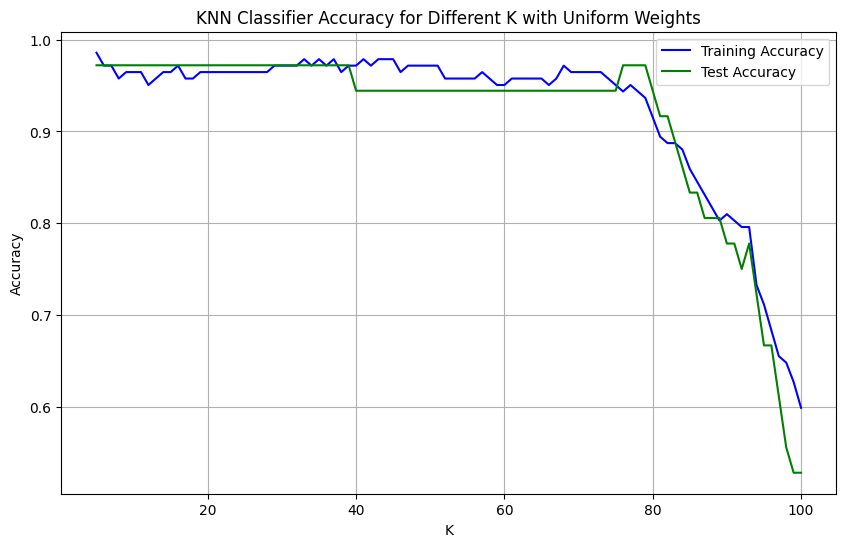

In [13]:
# Accuracy with "uniform" weights across different values of K
uniform_results = {'K': [], 'Train Accuracy': [], 'Test Accuracy': []}

for k in k_values:
    knn_uniform = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_uniform.fit(X_train_scaled, y_train)
    
    # Record accuracies
    train_acc = knn_uniform.score(X_train_scaled, y_train)
    test_acc = knn_uniform.score(X_test_scaled, y_test)
    
    uniform_results['K'].append(k)
    uniform_results['Train Accuracy'].append(train_acc)
    uniform_results['Test Accuracy'].append(test_acc)

# Create a DataFrame to store results
uniform_results_df = pd.DataFrame(uniform_results)

# Plot training and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(uniform_results_df['K'], uniform_results_df['Train Accuracy'], label='Training Accuracy', color='blue')
plt.plot(uniform_results_df['K'], uniform_results_df['Test Accuracy'], label='Test Accuracy', color='green')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Accuracy for Different K with Uniform Weights')
plt.legend()
plt.grid(True)
plt.show()


c.	[10 pts] Using the non-normalized training and test data, perform classification using scikit-learn's decision tree classifier (using the default parameters). As above, generate the confusion matrix, classification report, and average accuracy scores of the classifier. Compare the average accuracy score on the test and the training data sets. What does the comparison tell you in terms of bias-variance trade-off? Next, create another decision tree model (trained on the non-normalized training data) using "gini" index as the selection criteria, min_samples_split=10, and max_depth=4. Show the accuracy results for both the training and test sets. For this model generate a visualization of tree embedded in the Jupyter Notebook.
 


Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Training Accuracy: 1.0
Test Accuracy: 1.0
Training Accuracy (Gini): 0.9583333333333334
Test Accuracy (Gini): 1.0


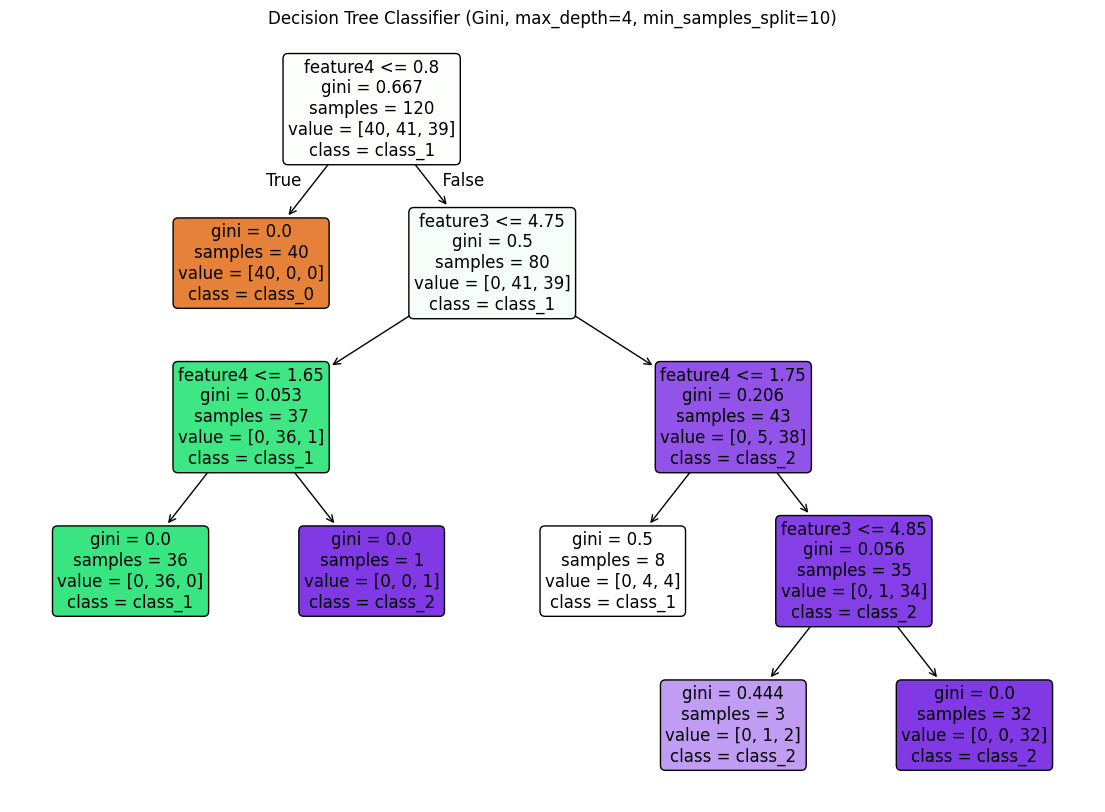

In [192]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Dummy feature names (replace with your actual feature names)
feature_names = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6']  # Update accordingly

# Initialize Decision Tree Classifier with default parameters
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Predictions
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Accuracy scores
train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Decision Tree with Gini index, min_samples_split=10, and max_depth=4
dt_gini = DecisionTreeClassifier(criterion='gini', min_samples_split=10, max_depth=4)
dt_gini.fit(X_train, y_train)

# Accuracy scores for the new decision tree
train_accuracy_gini = dt_gini.score(X_train, y_train)
test_accuracy_gini = dt_gini.score(X_test, y_test)
print(f"Training Accuracy (Gini): {train_accuracy_gini}")
print(f"Test Accuracy (Gini): {test_accuracy_gini}")

# Improved Plot for Decision Tree
plt.figure(figsize=(14, 10))  # Larger figure for better clarity
plot_tree(dt_gini, 
          filled=True, 
          feature_names=feature_names, 
          class_names=wine.target_names, 
          rounded=True,  # Rounded corners for a cleaner look
          fontsize=12)   # Larger font size for readability
plt.title("Decision Tree Classifier (Gini, max_depth=4, min_samples_split=10)")
plt.show()


d.	[10 pts] Use scikit-learn to build classifiers using Naive Bayes (Gaussian) and linear discriminant analysis (LDA).  For each of these perform 10-fold cross-validation on the 80% training data (using cross-validation module in scikit-learn) and report the overall average accuracy. Compare this cross-validation accuracy to the model accuracy on the training data as a whole. Finally, run your model on the set-aside 20% test data.


In [151]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

# Naive Bayes Classifier
nb = GaussianNB()
nb_cv_scores = cross_val_score(nb, X_train, y_train, cv=10)
print(f"Naive Bayes 10-fold Cross-Validation Average Accuracy: {nb_cv_scores.mean()}")

# LDA Classifier
lda = LinearDiscriminantAnalysis()
lda_cv_scores = cross_val_score(lda, X_train, y_train, cv=10)
print(f"LDA 10-fold Cross-Validation Average Accuracy: {lda_cv_scores.mean()}")

# Train on the entire training set and test on the test set
nb.fit(X_train, y_train)
lda.fit(X_train, y_train)

# Test accuracy on the test set
nb_test_accuracy = nb.score(X_test, y_test)
lda_test_accuracy = lda.score(X_test, y_test)

print(f"Naive Bayes Test Accuracy: {nb_test_accuracy}")
print(f"LDA Test Accuracy: {lda_test_accuracy}")


Naive Bayes 10-fold Cross-Validation Average Accuracy: 0.9416666666666667
LDA 10-fold Cross-Validation Average Accuracy: 0.975
Naive Bayes Test Accuracy: 1.0
LDA Test Accuracy: 1.0
